In [1]:
using Random
Random.seed!(51233) # Set random seed

using PyPlot
using ForneyLab

include("environment.jl") # Load environmental dynamics (initializeWorld)
include("helpers.jl") # Load visualization (plotTrajectory)
;

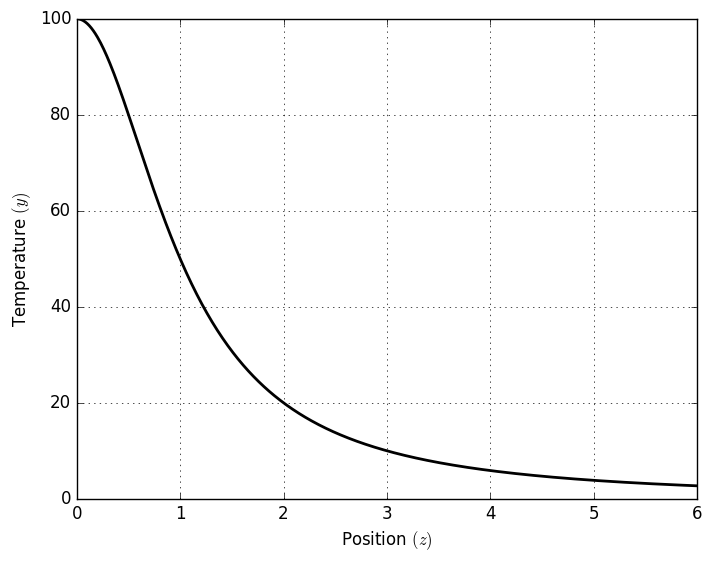

In [2]:
plotLandscape() # Visualize (hidden) temperature landscape
;

In [3]:
T = 100 # Total simulation time
action_onset = 25 # Actions are only allowed after a specific time

include("agent.jl") # Load agent prior beliefs (initializeAgent)

# Internal model parameters
gamma = 100.0 # State transition precision
theta = 0.01 # Observation variance
;

<img src="./figures/model.png">

In [4]:
# Build internal model
fg = FactorGraph()

x = Vector{Variable}(undef, T) # Observed states
s = Vector{Variable}(undef, T) # Brain states
u = Vector{Variable}(undef, T) # Control states

@RV s_0 ~ GaussianMeanVariance(0.0, huge) # Initial brain state

s_t_min = s_0
for t = 1:T
    @RV u[t] ~ GaussianMeanVariance(placeholder(:m_u, var_id=:m_u_*t, index=t), 
                                    placeholder(:v_u, var_id=:v_u_*t, index=t)) # Control prior
    @RV s[t] ~ GaussianMeanPrecision(s_t_min + u[t], gamma) # State transition model
    @RV x[t] ~ GaussianMeanVariance(-1.0*s[t], theta) # Observation model
    GaussianMeanVariance(x[t], 
                         placeholder(:m_x, var_id=:m_x_*t, index=t), 
                         placeholder(:v_x, var_id=:v_x_*t, index=t)) # Goal prior
    s_t_min = s[t]
end
;

In [5]:
# Schedule message passing algorithm
algo = sumProductAlgorithm([s; u]) # Infer internal states
eval(Meta.parse(algo)) # This evaluation loads the step!() function for inference

inspectSnippet(algo) # Print a snippet of the automatically generated algorithm code
;

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 1098))

messages[1] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=1.0e12))
messages[2] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=data[:m_u][1]), Message(Univariate, PointMass, m=data[:v_u][1]))
messages[3] = ruleSPAdditionOutVGG(nothing, messages[1], messa

...

marginals[:u_98] = messages[23].dist * messages[1096].dist
marginals[:u_99] = messages[16].dist * messages[1097].dist
marginals[:u_100] = messages[9].dist * messages[1098].dist

return marginals

end


In [6]:
(execute, observe)  = initializeWorld() # Let there be a world
(infer, act, slide) = initializeAgent() # Let there be an agent

# Step through the experimental protocol
a     = Vector{Float64}(undef, T) # Actions
y_hat = Vector{Float64}(undef, T) # Environmental outcomes
for t = 1:T
    a[t]     = act(t) # Evoke an action from the agent
               execute(a[t]) # The action influences hidden external states
    y_hat[t] = observe() # Observe the current environmental outcome (update p)
               infer(a[t], y_hat[t], t) # Infer beliefs from current model state (update q)
               slide() # Prepare model for next iteration
end
;

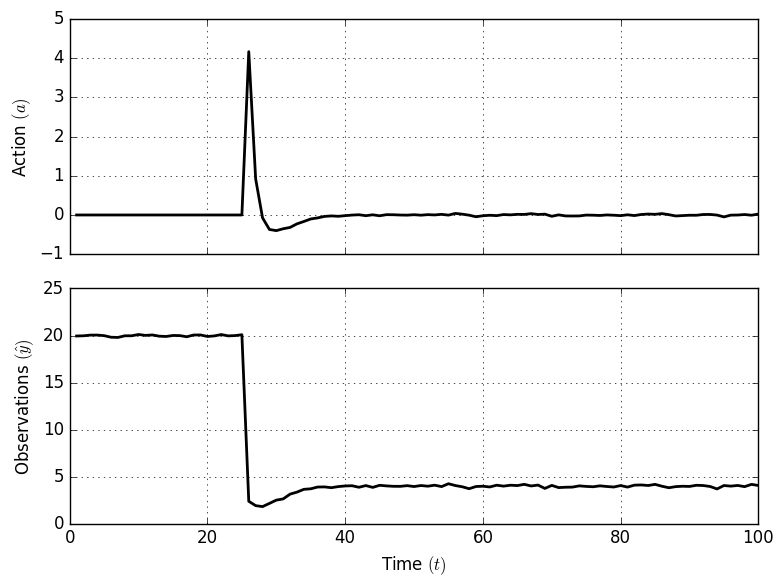

In [7]:
plotTrajectory(a, y_hat)
;